In [130]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima   

In [2]:
pwd

'/Users/panos/Documents/Work/aueb/students/darzanos/LoadPrediction'

In [3]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Load Demand_Forecast.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [4]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [53]:
#create one dataframe from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [54]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [55]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head()

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-12-01,1,33.006141,934.808670,0.0,954.722055,4595.257242,5563.072052
1,2018-12-01,2,43.988918,959.233194,0.0,931.364922,4063.666352,5066.888464
2,2018-12-01,3,46.329801,970.324019,0.0,910.726163,3938.994044,4955.647864
3,2018-12-01,4,36.405052,995.836951,0.0,901.447118,3755.516237,4787.758241
4,2018-12-01,5,36.149028,991.074298,0.0,896.550351,3646.883398,4674.106724


- Date,Hour=Ημερομηνια Αναφοράς
- Gen_Aux=φορτιο παραγωγής μονάδων
- HV=Φορτίο Υψηλής τάσης
- Pump=Αναμενω ενημέρωση
- Network (ΜΤ+ΧΤ)= μας δίνει το συνολικό actual φορτίο
- TEL_MV=Φορτιο της τηλεμετρουμενης μεσης τασης.
- ΧΤ= Η στηλη που δημιουργώ αφαιρώντας την τηλεμετρουμενη ΜΤ από το Network και βρίσκω την actual total XT που θέλω να προβλεψω.
- ActualTotal= Το αθροισμα των Network+HV+Gen_Aux+Pump που μας δίνει το συνολικό φορτίο. Αυτό θα το χρησιμοποιήσω αργότερα για να βρω τι ποσοστό είναι η ΧΤ σε σχέση με το ActualTotal.



In [56]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [57]:
forecast.head()

,Year,Month,Weekday,Holiday,Date,1,2,3,4,5,...,21,22,23,24,Sum,Avrg,Max,Min,Δ vs D-1,Δ vs D-7
0,2018,1,1,1,2018-01-01,5315.0,4963.0,4838.0,4515.0,4280.0,...,6198.0,6021.0,5756.0,5513.0,127512.0,5313.000000,6237.0,4182.0,-0.112966,-0.077077
1,2018,1,2,0,2018-01-02,5023.0,4612.0,4573.0,4389.0,4250.0,...,6831.0,6517.0,6106.0,5717.0,135940.0,5664.166667,6927.0,4250.0,0.066096,-0.011101
2,2018,1,3,0,2018-01-03,5211.0,4761.0,4721.0,4547.0,4438.0,...,7409.0,6949.0,6411.0,5962.0,146200.0,6091.666667,7554.0,4438.0,0.075474,-0.001666
3,2018,1,4,0,2018-01-04,5307.0,4788.0,4721.0,4525.0,4427.0,...,7483.0,7014.0,6476.0,6038.0,149234.0,6218.083333,7649.0,4427.0,0.020752,0.020194
4,2018,1,5,0,2018-01-05,5420.0,4932.0,4865.0,4718.0,4621.0,...,7453.0,6984.0,6455.0,6037.0,149052.0,6210.500000,7550.0,4621.0,-0.001220,0.010892


In [58]:
#data manipulation to create new dataframe
forecast = forecast.iloc[:, 2:-6]
prediction = pd.melt(forecast, 
                     id_vars=["Weekday", "Holiday", "Date"], 
                     var_name='Hour', 
                     value_name='ForecastTotalLoad')
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [59]:
prediction.tail(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
12374,3,0,2019-05-22,24,5066.0
12375,4,0,2019-05-23,24,5126.0
12376,5,0,2019-05-24,24,5092.0
12377,6,0,2019-05-25,24,4961.0
12378,7,0,2019-05-26,24,4802.0
12379,1,0,2019-05-27,24,5093.0
12380,2,0,2019-05-28,24,5088.0
12381,3,0,2019-05-29,24,5111.0
12382,4,0,2019-05-30,24,5185.0
12383,5,0,2019-05-31,24,5105.0


In [60]:
#εδω αφαίρω μια ωρα για να φτάσω στο format 0-23 ωρες ωστε να γλυτώσω αυτό με το timestamp + 1
actual['Hour']=actual['Hour']-1
prediction['Hour']=prediction['Hour']-1
prediction.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,0,5315.0
1,2,0,2018-01-02,0,5023.0
2,3,0,2018-01-03,0,5211.0
3,4,0,2018-01-04,0,5307.0
4,5,0,2018-01-05,0,5420.0


- ForecastTotalLoad είναι η προβλεψη για το συνολικό actual φορτίο όπως την κάνουν τωρα και πρέπει να συγκριθεί με την αντίστοιχη τιμή πιο πανω του ActualTotal.

In [61]:
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV  Pump      TEL_MV      Network  \
Date       Hour                                                         
2018-12-01 0     33.006141  934.808670   0.0  954.722055  4595.257242   
           1     43.988918  959.233194   0.0  931.364922  4063.666352   
           2     46.329801  970.324019   0.0  910.726163  3938.994044   
           3     36.405052  995.836951   0.0  901.447118  3755.516237   
           4     36.149028  991.074298   0.0  896.550351  3646.883398   

                 ActualTotal  
Date       Hour               
2018-12-01 0     5563.072052  
           1     5066.888464  
           2     4955.647864  
           3     4787.758241  
           4     4674.106724

In [62]:
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,0,1,1,5315.0
2018-01-02,0,2,0,5023.0
2018-01-03,0,3,0,5211.0
2018-01-04,0,4,0,5307.0
2018-01-05,0,5,0,5420.0


* Join the two dataframes.

In [63]:
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [64]:
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05


In [65]:
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00
516,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00
1032,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00
1548,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00
2064,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00


In [66]:
final.tail()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
10319,5,0,2019-05-31,19,5572.0,33.211102,876.113437,0.0,1397.706018,4901.567117,5810.891656,2019-05-31 19:00:00
10835,5,0,2019-05-31,20,5740.0,32.731239,890.764508,0.0,1355.517513,5000.305264,5923.801011,2019-05-31 20:00:00
11351,5,0,2019-05-31,21,5915.0,32.180987,861.846122,0.0,1268.293778,5123.894570,6017.921678,2019-05-31 21:00:00
11867,5,0,2019-05-31,22,5506.0,33.389455,856.024205,0.0,1152.098123,4680.730403,5570.144063,2019-05-31 22:00:00
12381,5,0,2019-05-31,23,5105.0,35.753307,964.764549,0.0,1092.041595,4227.795192,5228.313048,2019-05-31 23:00:00


In [67]:
#create the column of interest
final['XT'] = final['Network'] - final['TEL_MV']

#find the percentage of XT as to total ActualLoad for that day and Hour (TrueValues)
final['%XTofTotal']=final['XT']/final['ActualTotal']

#find the estimation of XTPrediction
final['XTForecastEstimation']=final['%XTofTotal']*final['ForecastTotalLoad']


Στο παραπάνω κελι αφού δημιουργήσω τη στηλη με τις actual τιμές της ΧΤ υπολογίζω το ποσοστό που έπιανε η ΧΤ σε σχέση με το σύνολο του φορτίου για εκείνη τη μέρα ώρα. Βρίσκοντας το ποσοστό, το εφαρμόζω μετά στην πρόβλεψη που δίνει το μοντέλο τους (το μοντέλο τους προβλέπει το σύνολικό φορτίο του δυκτίου) για να μπορέσω να προσεγγίσω την πρόβλεψη του μοντέλου αν προέβλεπε τη χαμηλή τάση. Θα το χρησιμοποιήσω στη σύγκριση μεταξυ του δικού μας και του δικού τους μοντέλου όπως είπαμε.

In [68]:
#finalize dataset and set frequency
final=final[['Timestamp','XT','Weekday','Holiday','XTForecastEstimation']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

In [69]:
final

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
2018-01-01 05:00:00,2934.418572,1,1,2624.699069
2018-01-01 06:00:00,2990.903843,1,1,2645.526199
2018-01-01 07:00:00,3048.662534,1,1,2778.846267
2018-01-01 08:00:00,3189.215049,1,1,3011.633638


* Check the index for the frequency (should be hourly).

In [70]:
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-05-31 14:00:00', '2019-05-31 15:00:00',
               '2019-05-31 16:00:00', '2019-05-31 17:00:00',
               '2019-05-31 18:00:00', '2019-05-31 19:00:00',
               '2019-05-31 20:00:00', '2019-05-31 21:00:00',
               '2019-05-31 22:00:00', '2019-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12382, freq=None)

* The `None` reported value indicates that there might be missing values.

In [71]:
#nice
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-25 23:00:00', '2019-03-31 23:00:00'], dtype='datetime64[ns]', freq=None)

* Let's check what happens around the first date.

In [72]:
final.loc['2018-03-25':'2018-03-26']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 00:00:00,3147.824162,7,1,3171.278635
2018-03-25 01:00:00,2740.862797,7,1,2745.225070
2018-03-25 02:00:00,2654.360886,7,1,2648.583949
2018-03-25 03:00:00,2507.887529,7,1,NaN
2018-03-25 04:00:00,2440.072651,7,1,2506.587454
2018-03-25 05:00:00,2515.380769,7,1,2532.772226
2018-03-25 06:00:00,2612.671803,7,1,2604.791065
2018-03-25 07:00:00,2930.827226,7,1,2807.819204
2018-03-25 08:00:00,3306.252447,7,1,3126.662986


* There is a missing hour from March 25 to March 26, 2018 (jump from 22:00:00 to 00:00:00).

* Let's also check what is happening with the second date.

In [76]:
final.loc['2019-03-31':'2019-04-01']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2019-03-31 00:00:00,3301.206709,7,0,3247.902346
2019-03-31 01:00:00,2873.602290,7,0,2819.229247
2019-03-31 02:00:00,2747.037509,7,0,2732.615475
2019-03-31 03:00:00,2588.609454,7,0,2603.115607
2019-03-31 04:00:00,2508.161442,7,0,2440.825764
2019-03-31 05:00:00,2584.451302,7,0,2492.355395
2019-03-31 06:00:00,2782.655535,7,0,2586.818830
2019-03-31 07:00:00,3116.754635,7,0,2827.044553
2019-03-31 08:00:00,3392.986697,7,0,3069.195420


* Same story, an hour was skipped between March 31 and April 1, 2019.

* We'll fix the issue by using the previous value.

In [77]:
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-05-31 14:00:00', '2019-05-31 15:00:00',
               '2019-05-31 16:00:00', '2019-05-31 17:00:00',
               '2019-05-31 18:00:00', '2019-05-31 19:00:00',
               '2019-05-31 20:00:00', '2019-05-31 21:00:00',
               '2019-05-31 22:00:00', '2019-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12384, freq='H')

In [78]:
#check again for NaN in dataframe γιατι τώρα που κουβαλάω και την επιπλέον στήλη εχω το ίδιο θέμα με την ώρα
final[final.isnull().any(axis=1)]

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 03:00:00,2507.887529,7,1,NaN


In [79]:
#NaN that day for forecastedValues
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation            NaN
Name: 2018-03-25 03:00:00, dtype: float64

In [80]:
#fill with previous value ΝαΝ
final=final.fillna(method='ffill')

In [81]:
#fixed
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation    2648.583949
Name: 2018-03-25 03:00:00, dtype: float64

In [82]:
#Here is going to be the EDA part-just some quick insights

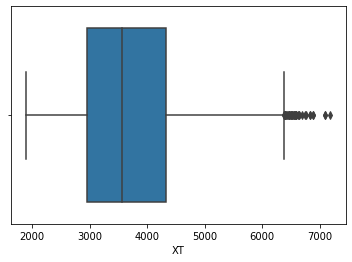

In [83]:
#there are some outliers
import seaborn as sns
sns.boxplot(x=final['XT'])

In [84]:
#check largest Values-seems logical not extreme values
print( final['XT'].nlargest(100))

Timestamp
2019-01-08 19:00:00    7187.273484
2019-01-08 18:00:00    7092.001648
2019-01-08 20:00:00    7087.291997
2019-01-07 19:00:00    6889.243639
2018-12-31 19:00:00    6886.460958
2019-01-07 18:00:00    6841.067931
2018-12-31 18:00:00    6840.916882
2019-01-07 20:00:00    6772.561301
2019-01-09 19:00:00    6748.768014
2019-01-09 18:00:00    6702.761760
2019-01-09 20:00:00    6641.248381
2019-01-15 19:00:00    6635.899723
2019-01-09 12:00:00    6633.942155
2019-01-04 18:00:00    6599.238771
2019-01-09 13:00:00    6593.872701
2019-01-08 21:00:00    6591.192022
2019-01-04 19:00:00    6584.377349
2019-01-15 20:00:00    6577.317376
2019-01-09 11:00:00    6572.505436
2019-01-09 15:00:00    6559.546339
2018-12-31 20:00:00    6550.001520
2019-01-05 19:00:00    6537.056744
2019-02-25 19:00:00    6521.003890
2019-01-08 12:00:00    6519.530777
2019-01-15 18:00:00    6510.671720
2019-01-05 18:00:00    6506.745135
2019-01-09 16:00:00    6491.477401
2019-01-08 17:00:00    6471.302820
2019-02-25

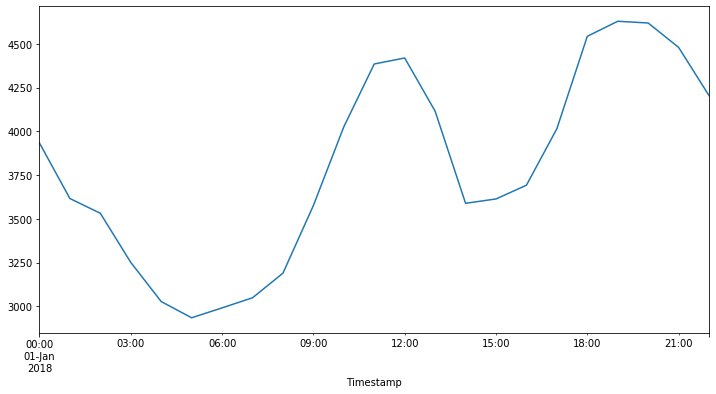

In [85]:
final['XT'].iloc[:23].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

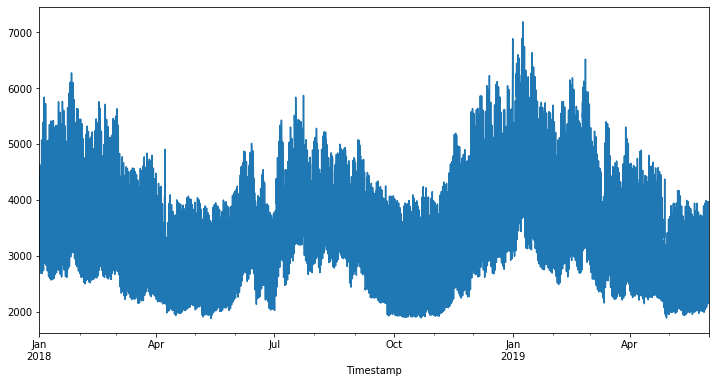

In [86]:
final['XT'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Text(0, 0.5, 'Residual')

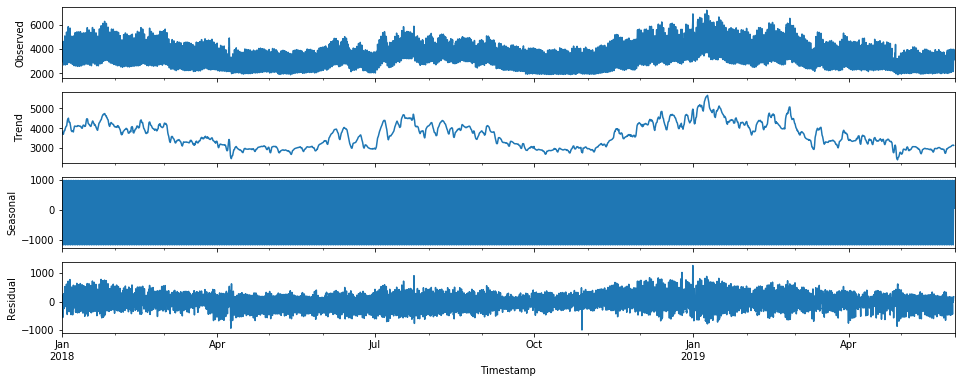

In [87]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,6))

result = seasonal_decompose(final['XT'])

result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

In [88]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [89]:
#what about that test???
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(series):
    print ('Results of KPSS Test:')
    kpsstest = kpss(series, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [90]:
kpss_test(final['XT'])

Results of KPSS Test:
Test Statistic            1.407177
p-value                   0.010000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


kpss Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, we fail to reject the null hypothesis (series is stationary). The value of the test statistic is greater than the critical value at all confidence intervals, and hence we can say that the series is not stationary.

In [91]:
adf_test(final['XT'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.934115
p-value                     0.001798
# lags used                41.000000
# observations          12342.000000
critical value (1%)        -3.430880
critical value (5%)        -2.861774
critical value (10%)       -2.566895
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Στο analyticsVidhya διάβασα αυτό.
KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [92]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(final['XT'].loc['2018-05-01':'2019-05-01'], seasonal=True, m=24).summary()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2) seasonal_order=(1, 0, 1, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 0) seasonal_order=(2, 0, 1, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pmdarima/arima/_auto_solve

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8784
Model:             SARIMAX(1, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -48606.019
Date:                            Thu, 25 Jul 2019   AIC                          97224.037
Time:                                    22:17:14   BIC                          97266.521
Sample:                                         0   HQIC                         97238.511
                                           - 8784                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0150      0.059     -0.253      0.800      -0.131       0.101
ar.L1          0.5681      0.004    131.403      0.000       0.560       0.577
ar.S.L24       1.2441      0.009    144.582      0.000       1.227       1.261
ar.S.L48      -0.2443      0.009    -28.418      0.000      -0.261      -0.227
ma.S.L24      -0.7917      0.006   -129.930      0.000      -0.804      -0.780
sigma2      3696.9293     20.271    182.372      0.000    3657.198    3736.660
===================================================================================
Ljung-Box (Q):                     1762.36   Jarque-Bera (JB):             83121.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
#use the period used for training
df1=final.loc['2018-05-01':'2019-05-01']
df1.shape

(8784, 4)

* Use all data except the last two days for training and the last two days for testing.

In [106]:
train = df1.iloc[:-24*2]
train.tail()

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2019-04-29 19:00:00,2716.197800,1,1,2856.265803
2019-04-29 20:00:00,3176.780529,1,1,3376.516734
2019-04-29 21:00:00,3420.051102,1,1,3543.633931
2019-04-29 22:00:00,3165.840760,1,1,3238.206109
2019-04-29 23:00:00,2840.635600,1,1,2878.358634


* Get the last two days for testing.

In [108]:
test = df1.iloc[-24*2:]
test.head()

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2019-04-30 00:00:00,2501.842601,2,0,2480.647621
2019-04-30 01:00:00,2229.336789,2,0,2213.842019
2019-04-30 02:00:00,2090.021816,2,0,2108.421108
2019-04-30 03:00:00,2001.966833,2,0,2005.395764
2019-04-30 04:00:00,1977.424776,2,0,1959.676271


In [109]:
#run model
model = SARIMAX(train['XT'],
                exog=train[['Weekday','Holiday']],
                order=(1,1,0),
                seasonal_order=(2,0,1,24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 XT   No. Observations:                 8736
Model:             SARIMAX(1, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -48337.953
Date:                            Fri, 26 Jul 2019   AIC                          96689.905
Time:                                    06:59:38   BIC                          96739.431
Sample:                                05-01-2018   HQIC                         96706.783
                                     - 04-29-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weekday        2.6108      1.195      2.184      0.029       0.268       4.953
Holiday       27.4507      6.509      4.217      0.000      14.693      40.208
ar.L1          0.5697      0.004    130.783      0.000       0.561       0.578
ar.S.L24       1.2484      0.009    144.742      0.000       1.231       1.265
ar.S.L48      -0.2486      0.009    -28.860      0.000      -0.265      -0.232
ma.S.L24      -0.7933      0.006   -130.159      0.000      -0.805      -0.781
sigma2      3697.0447     20.317    181.972      0.000    3657.225    3736.864
===================================================================================
Ljung-Box (Q):                     1729.63   Jarque-Bera (JB):             82948.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.67   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday','Weekday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, 
                              end=end, 
                              exog=exog_forecast).rename('SARIMAX(1,1,0)(2,0,1,24) Predictions')

In [128]:
test['XT'].sum()

132373.882618728

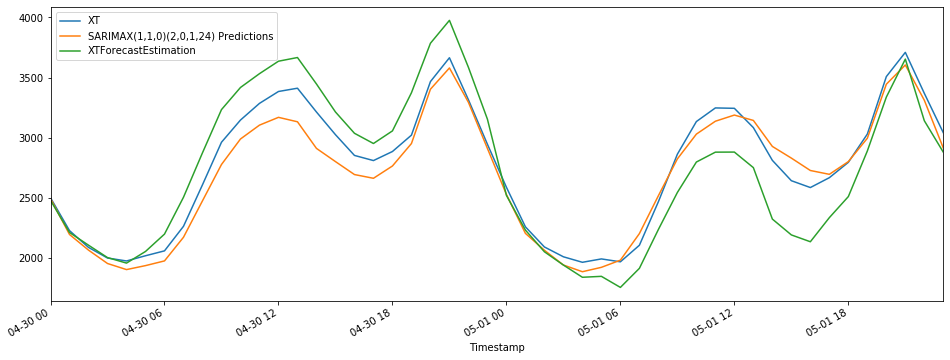

In [142]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['XT'], label='XT')
predictions.plot(legend=True, axes=axes)
final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [144]:
from statsmodels.tools.eval_measures import mse,rmse

our_error = rmse(test['XT'], predictions)
their_error = rmse(final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'], test['XT'])

In [145]:
their_error

243.02998816611498

In [146]:
#WIN??
our_error

116.87128474378312

# Prophet

In [101]:
#import ProphetLibrary
from fbprophet import Prophet

In [240]:
#create holidays Dataframe for possible use by Prophet
holidays = pd.DataFrame({
    'ds': train.reset_index().query('Holiday == 1')['Timestamp'],
    'holiday': 'holiday'
})
holidays.head()

,ds,holiday
0,2018-05-01 00:00:00,holiday
1,2018-05-01 01:00:00,holiday
2,2018-05-01 02:00:00,holiday
3,2018-05-01 03:00:00,holiday
4,2018-05-01 04:00:00,holiday


In [251]:
#fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)#, holidays=holidays)
prophet_model.fit(train['XT'].reset_index().rename(columns={'Timestamp':'ds', 'XT':'y'}))

In [252]:
#predict
prophet_forecast = prophet_model.predict(df=test['XT'].reset_index().rename(columns={'Timestamp':'ds'}))

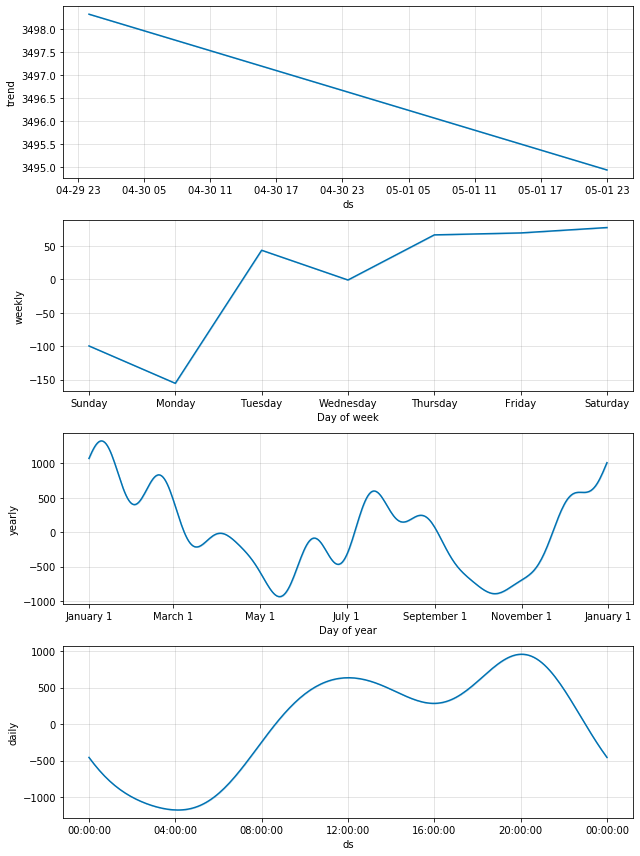

In [253]:
_ = prophet_model.plot_components(prophet_forecast)

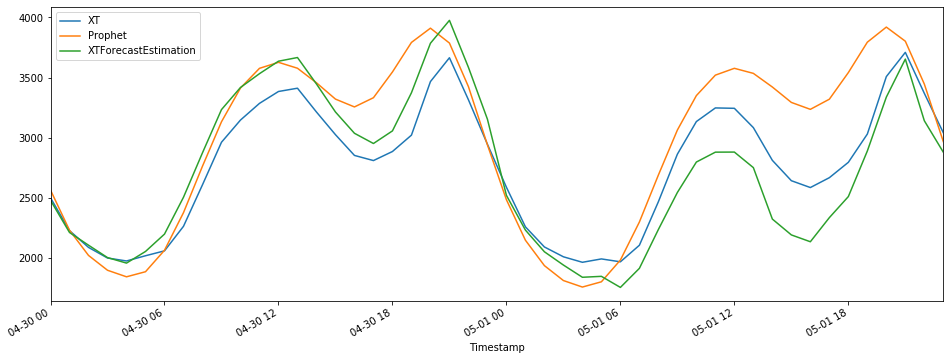

In [254]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['XT'], label='XT')
axes.plot(test.index, prophet_forecast['yhat'], label='Prophet', axes=axes)
final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [255]:
#calculate Error
prophet_error= rmse(test['XT'], prophet_forecast['yhat'])

In [256]:
#worse
prophet_error

350.17656425481243

# RNN

In [95]:
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

Using TensorFlow backend.
